# Gaussian Mixture Model (GMM) Clustering

K-Means overfit and didn’t capture the real structure of our data. It only gave me two clusters, which seems too simplistic and likely missed important differences between patient subgroups. It also assumes clusters are spherical and of equal variance, which isn’t realistic for our biomarker data. GMM (Gaussian Mixture Models), on the other hand, is more flexible—it allows for elliptical clusters and uses probabilistic assignments, making it better suited for complex, overlapping distributions. By switching to GMM, we hope to capture more meaningful biological and clinical subphenotypes rather than forcing the data into rigid groupings.

Reference: [k-means-clustering-vs-gaussian-mixture](https://medium.com/@amit25173/k-means-clustering-vs-gaussian-mixture-bec129fbe844)

## 1. Import necessary libraries, have function definitions

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

In [13]:
# Determines the optimal number of clusters (k) for GMM using BIC & AIC
# reference: https://stats.stackexchange.com/questions/32400/optimal-number-of-components-in-a-gaussian-mixture
# reference: https://pm.jh.edu/cookbook/PythonDataScienceHandbook/notebooks/05.12-Gaussian-Mixtures.html
def find_optimal_clusters_gmm(data, max_clusters=10, random_state=30):
    bic_scores = []
    aic_scores = []
    k_values = range(2, max_clusters + 1)

    for k in k_values:
        gmm = GaussianMixture(n_components=k, random_state=random_state, n_init=10)
        gmm.fit(data)
        bic_scores.append(gmm.bic(data))
        aic_scores.append(gmm.aic(data))

    # Plot BIC and AIC scores
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, bic_scores, marker='o', label="BIC Score")
    plt.plot(k_values, aic_scores, marker='s', label="AIC Score")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Score")
    plt.title("BIC & AIC Scores for GMM")
    plt.legend()
    plt.show()

    # Print the optimal k
    optimal_k_bic = k_values[np.argmin(bic_scores)]
    optimal_k_aic = k_values[np.argmin(aic_scores)]
    print(f"Optimal k based on BIC: {optimal_k_bic}")
    print(f"Optimal k based on AIC: {optimal_k_aic}")


In [14]:
# Perform GMM clustering and assign cluster labels to the dataset.
def assign_clusters_gmm(data, optimal_k, random_state=30):
    df = data.copy()
    gmm = GaussianMixture(n_components=optimal_k, random_state=random_state, n_init=10)
    df['Cluster'] = gmm.fit_predict(df)
    return df


In [15]:
# Perform PCA to reduce dimensions and visualize clusters in 2D.
def visualize_clusters_2D_pca(df, cluster_column='Cluster', n_components=2, colors=None):
    numeric_data = df.drop(columns=[cluster_column])
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(numeric_data)

    # Convert to DataFrame for visualization
    pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df[cluster_column] = df[cluster_column].values

    # Plot PCA scatter plot
    palette = colors if colors else "viridis"
    plt.figure(figsize=(10, 5))
    sns.scatterplot(
        x=pca_df['PC1'],
        y=pca_df['PC2'],
        hue=pca_df[cluster_column],
        palette=palette,
    )
    plt.title("Visualization of Clusters (2D)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title=cluster_column)
    plt.show()


In [16]:
# Perform PCA to reduce dimensions and visualize clusters in 3D.
def visualize_clusters_3D_pca(df, cluster_column='Cluster', n_components=3, colors=None):
    numeric_data = df.drop(columns=[cluster_column])
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(numeric_data)

    # Convert to DataFrame for visualization
    pca_df = pd.DataFrame(pca_data, columns=[f'PCA{i+1}' for i in range(n_components)])
    pca_df[cluster_column] = df[cluster_column].values

    # Plot 3D scatter plot
    palette = colors if colors else "viridis"
    fig = px.scatter_3d(
        pca_df, 
        x='PCA1', 
        y='PCA2', 
        z='PCA3', 
        color=cluster_column,
        title='Visualization of Clusters (3D)',
        color_continuous_scale=palette,
    )
    
    fig.show()


## 2. Load the data

In [17]:
# Load the biomarker data that we cleaned and scaled in N1_biomarker_data_cleaning.py
biomarker_df_file_path = "../data/clean_data/scaled_biomarker_data.csv"
biomarker_df = pd.read_csv(biomarker_df_file_path)
biomarker_df.head()

,balf_Amphiregulin_V1_imputed,balf_Calprotectin_V1_imputed,balf_CD163_V1_imputed,balf_IL-8_chemo_V1_imputed,balf_IP-10_chemo_V1_imputed,balf_MCP-1_chemo_V1_imputed,balf_MCP-4_chemo_V1_imputed,balf_TARC_chemo_V1_imputed,balf_GM-CSF_V1_imputed,balf_IL-12/IL-23p40_V1_imputed,balf_IL-15_V1_imputed,balf_IL-16_V1_imputed,balf_IL-17A_V1_imputed,balf_IL-7_V1_imputed,balf_VEGF_V1_imputed,balf_G-CSF_V1_imputed,balf_PD-L1_V1_imputed,balf_IL-6_proinf_V1_imputed,balf_sRAGE_V1_imputed,balf_TNF-RI_V1_imputed
0,-1.470130,-1.498284,-0.246658,-1.129279,-0.614070,-0.030338,-0.866099,-0.440824,-0.655745,-1.162979,0.375604,-0.695447,-1.099571,0.286584,0.352247,-1.095234,-0.887325,-1.598728,-0.288758,-1.412866
1,0.803770,0.911863,1.228127,-3.101678,-2.734490,-2.711906,-1.388472,-1.679053,-0.042735,1.728370,0.789723,1.435168,2.252914,0.530009,0.845505,1.136749,1.368696,1.138960,0.049796,0.753702
2,0.553875,0.576147,-0.224706,0.996641,-0.032357,0.089440,-0.522827,-0.620921,-0.935185,0.064120,-1.590510,0.092549,-0.101333,-0.558272,0.403123,0.351343,-0.339183,1.136237,0.310366,0.560863
3,-1.671626,-0.889214,-0.380679,-0.493922,-0.726075,0.811831,0.090998,-0.737614,-0.720736,-0.498054,0.685410,-1.272986,-0.815376,-0.952069,-0.559623,-0.522124,-0.689435,-1.015348,-0.573650,-1.044524
4,1.005517,1.199630,-0.851120,0.776083,0.854145,-0.590079,-0.351586,-0.139260,-0.981345,0.360495,-1.226081,1.447499,0.130569,0.644662,1.273656,0.558921,-0.019721,0.442616,-1.536270,0.599358


## 3. Clustering

First, let us perform clustering on the biomarket dataset that also have correlated columns


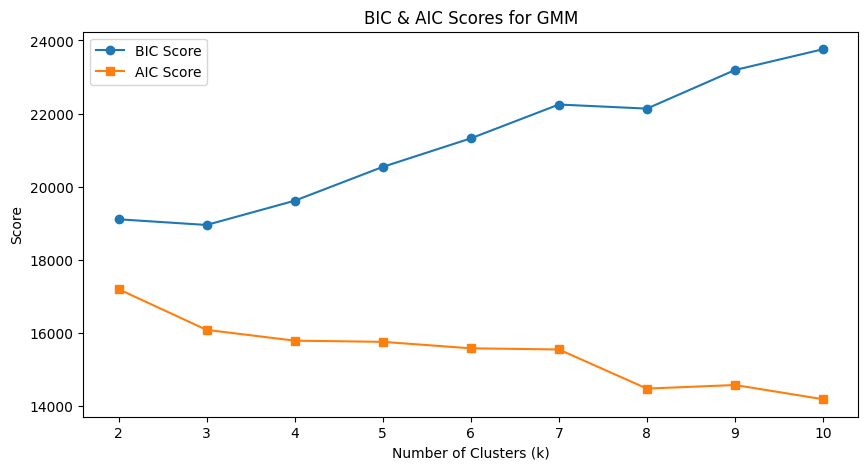

Optimal k based on BIC: 3
Optimal k based on AIC: 10


In [18]:
find_optimal_clusters_gmm(biomarker_df)

- BIC initially decreases but then starts increasing around K = 4 or 5, suggesting that adding more clusters beyond this point does not improve the model significantly.
- AIC continues to decrease, but AIC tends to favor more complex models, so we rely more on BIC for optimal cluster selection.

Since BIC is lowest around K = 4 or 5 before it starts rising, K = 4 or 5 is the most reasonable choice for the best balance between model complexity and goodness of fit.

We will be choosing k=4 for the rest of the analysis.

In [19]:
biomarker_df_with_clusters = assign_clusters_gmm(biomarker_df, 4)
biomarker_df_with_clusters.head()

,balf_Amphiregulin_V1_imputed,balf_Calprotectin_V1_imputed,balf_CD163_V1_imputed,balf_IL-8_chemo_V1_imputed,balf_IP-10_chemo_V1_imputed,balf_MCP-1_chemo_V1_imputed,balf_MCP-4_chemo_V1_imputed,balf_TARC_chemo_V1_imputed,balf_GM-CSF_V1_imputed,balf_IL-12/IL-23p40_V1_imputed,...,balf_IL-16_V1_imputed,balf_IL-17A_V1_imputed,balf_IL-7_V1_imputed,balf_VEGF_V1_imputed,balf_G-CSF_V1_imputed,balf_PD-L1_V1_imputed,balf_IL-6_proinf_V1_imputed,balf_sRAGE_V1_imputed,balf_TNF-RI_V1_imputed,Cluster
0,-1.470130,-1.498284,-0.246658,-1.129279,-0.614070,-0.030338,-0.866099,-0.440824,-0.655745,-1.162979,...,-0.695447,-1.099571,0.286584,0.352247,-1.095234,-0.887325,-1.598728,-0.288758,-1.412866,1
1,0.803770,0.911863,1.228127,-3.101678,-2.734490,-2.711906,-1.388472,-1.679053,-0.042735,1.728370,...,1.435168,2.252914,0.530009,0.845505,1.136749,1.368696,1.138960,0.049796,0.753702,2
2,0.553875,0.576147,-0.224706,0.996641,-0.032357,0.089440,-0.522827,-0.620921,-0.935185,0.064120,...,0.092549,-0.101333,-0.558272,0.403123,0.351343,-0.339183,1.136237,0.310366,0.560863,3
3,-1.671626,-0.889214,-0.380679,-0.493922,-0.726075,0.811831,0.090998,-0.737614,-0.720736,-0.498054,...,-1.272986,-0.815376,-0.952069,-0.559623,-0.522124,-0.689435,-1.015348,-0.573650,-1.044524,0
4,1.005517,1.199630,-0.851120,0.776083,0.854145,-0.590079,-0.351586,-0.139260,-0.981345,0.360495,...,1.447499,0.130569,0.644662,1.273656,0.558921,-0.019721,0.442616,-1.536270,0.599358,0


Let us now visualize the clusters in 2D and 3D to see if it makes sense.

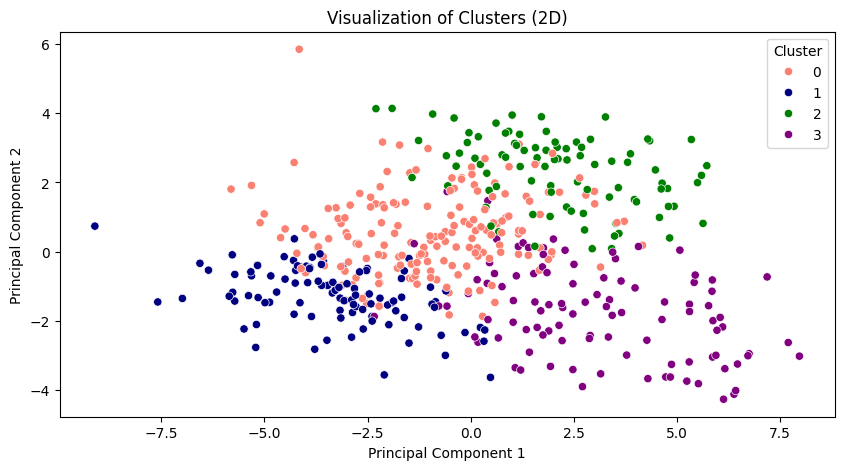

In [20]:
color_palette = ["salmon", "navy", "green", "purple"]#, "gold", "cyan"]
visualize_clusters_2D_pca(biomarker_df_with_clusters, colors=color_palette)

In [21]:
visualize_clusters_3D_pca(biomarker_df_with_clusters, colors=color_palette)

- Ideally, BIC should plateau or decrease consistently if adding clusters is improving the model. Here, BIC starts increasing after K = 5, meaning additional clusters might be overfitting instead of capturing meaningful subgroups.
- AIC is still going down, which suggests that more clusters improve the likelihood, but AIC often favors complex models, which can lead to overfitting. The fact that BIC and AIC are diverging means the model is struggling to find a clear cluster structure.
- In an ideal scenario, we expect BIC to drop sharply, then flatten, indicating a good balance between fit and complexity. Here, the decline isn’t strong enough, making it hard to justify a clear “best” k.
- Even if a statistical method picks K = 4 or 5, these clusters may not align with actual biological or clinical subphenotypes. If the clusters don’t show distinct biomarker patterns or clinical outcomes, then they aren’t useful.

GMM may not be the best approach; methods like Latent Class Analysis (LCA) or Hierarchical Clustering could reveal better structures. We will be trying our LCA later in R programming.

## 4. Save the dataframe

In [22]:
biomarker_df_with_clusters.to_csv("../data/clean_data/GMM_scaled_biomarker_data_with_clusters.csv", index=False)